In [4]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools

from time import strftime
%matplotlib inline



In [2]:
# helper line -> get different outpaths for sorted datasets; uncheck the date

#191021
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191021'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_adult_20min_spont_spikesorting'
# outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_adult_20min_spont0001_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_child_20min_spont0001_spikesorting'



#191021extra
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191021extra'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_23042021_hCSF_adult_20min_spont0002_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_29042021_hCSF_child_20min_spont_spikesorting'


#191017
mainpath = 'D:\Files_Reutlingen_Jenny\main_191017'
outpath = 'D:\Files_Reutlingen_Jenny\main_191017\_output_Spikesorting_30042021_spontaneous_spikesorting'



#191023
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191023'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_DNQX_AP5_washin_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_DNQX_AP5_washin0001_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_hCSF_afterDNQX_AP5_washin_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_spikesorting'


labeldic =  np.load(
    'D:\Files_Reutlingen_Jenny\_layerdictionaries\labeldictionary_MCS_256MEA.npy', 
    allow_pickle='TRUE').item() 

In [5]:
os.chdir(mainpath)
folderlist = glob.glob('*_output_Spikesorting*spikesorting*')

In [6]:
# loading functions

def load_dumped_subrecordings(directory, filebase):

    subrecording_dic = {}
    filelist = glob.glob('*recording.pkl')
    for file in filelist:
        key = file.split(filebase)[1].split('.')[0].split('_recording')[0]
        subrecording_dic[key]=se.load_extractor_from_pickle(file)
        
    return subrecording_dic
        
    
def load_dumped_sorted_dic(outpath):

    sorted_dic = {}
    filelist = glob.glob('*sorted*')
    for file in filelist:
        key = file.split('sorted_')[1]
        sorted_dic[key]=se.SpykingCircusSortingExtractor(file)
        
    return sorted_dic


# function to get the filebase from folder
def get_filebase_from_foldername(mainpath_folder):
    
    separator = '_'
    filebase = separator.join(mainpath_folder.split('\\')[-1].split('_')[4:-1])
    
    return filebase




def get_dictionary_keys(outpath_folder):

    dictkeys = []
    os.chdir(outpath_folder)
    folders_sorting = glob.glob('*sorted*')
    for i in folders_sorting:
        dk = i.split('sorted_')[1]
        dictkeys.append(dk)
    
    return dictkeys, print('Dictkeys are %s. Your CWD may have changed. Please check.' %dictkeys)



# function to convert basic information to dataframe
def units_to_pandas_DataFrame(sorted_dic, recording_cache, dictkey, layerdic_invert, recordingdate='not given'):
    
    # creates pandas DataFrame only including the unit ids. the order will be confused because of the unit numbering ('1' instead of '001')
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    unitframe = pd.DataFrame(
        sorted_dic[dictkey].get_unit_ids(), 
        columns=['unit_ids']
        )
    
    
    list_not_empty_spiketrains = []
    for i in unit_ids:
        st_len = len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        if st_len > 0:
            list_not_empty_spiketrains.append(i)
    
    
    # calculate as many paramters as possible outside of the loop
    recordings_seconds = recording_cache[dictkey].get_num_frames()/recording_cache[dictkey].get_sampling_frequency()
        
    for i in list_not_empty_spiketrains:  
        
        # add channel with maximum amplitude
        unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(
            recording_cache[dictkey], sorted_dic[dictkey], unit_ids=[i]
            )
        
        unitframe.loc[(unitframe['unit_ids']==i), 'unit_index']=unitframe.loc[(unitframe['unit_ids']==i)].index
    
        # get the channel label as on MCS MEA 256 chips
        max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
        unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]
        
        # get the number of spiks per unit
        unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        
        # add firing rate
        unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate']= unitframe.loc[(unitframe['unit_ids']==i)]['n_spikes']/recordings_seconds
        
        # add layer
        labelkey = unitframe.loc[(unitframe['unit_ids']==i), 'channellabel'].values[0]
        unitframe.loc[(unitframe['unit_ids']==i), 'layer']= layerdic_invert[labelkey]
        
       
        unitframe.loc[(unitframe['unit_ids']==i), 'file']=filebase
        unitframe.loc[(unitframe['unit_ids']==i), 'subrecording']=dictkey
        unitframe.loc[(unitframe['unit_ids']==i), 'recordingdate']=recordingdate
        # verify if this line works
        #unitframe.loc[(unitframe['unit_ids']==i), 'medium']=unitframe.loc[(unitframe['unit_ids']==i)]['file'].split('_')[0]
        
    return unitframe




def invert_layerdic(layer_dic):
    
    '''
    Expects a dictionary with key = layer, value = list of channellabels
    
    Returns a dictionary with key = channellabels, value = layer
    '''
    layerdic_invert = {}

    for key in layerdic:
        for i in layerdic[key]:
            layerdic_invert[i]=key
            
            
    return layerdic_invert
    

In [7]:
# get a filebaselist for every folder in the mainpath, that we we can filter 

filebase_list = []
for i in folderlist:
    filebase = get_filebase_from_foldername(i)
    filebase_list.append(filebase)

In [8]:
filebase_list

['spontaneous']

In [10]:
filebase = filebase_list[0]

In [11]:
outpath

'D:\\Files_Reutlingen_Jenny\\main_191017\\_output_Spikesorting_30042021_spontaneous_spikesorting'

In [12]:
os.chdir(outpath)

In [13]:
filelist = glob.glob('*')

In [14]:
filelist

['Cluster_190117_120seconds_50ms_bins_clustering.png',
 'DF_spontaneous_complete_df.pkl',
 'rasterplot_191017_120ms.png',
 'Smoothed_spikes_per_3ms.png',
 'sorted_sec_0-120',
 'spontaneoussec_0-120_filtered_data.dat',
 'spontaneoussec_0-120_recording.pkl',
 'spontaneous_DataFrame_dictionary.npy',
 'spontaneous_spiketrains_nested_per_channel_per_unit.npy',
 'spontaneous_spiketrains_per_channel.npy',
 'spontaneous_spiketrains_per_unit.npy',
 'spontaneous_spiketrains_per_unit.npy_SPADE_3.npy']

In [15]:
outpath

'D:\\Files_Reutlingen_Jenny\\main_191017\\_output_Spikesorting_30042021_spontaneous_spikesorting'

In [16]:
# within outpath, we need to have the different keys that comprise our spikesorting dictionary

dictionary_keys = get_dictionary_keys(outpath)


Dictkeys are ['sec_0-120']. Your CWD may have changed. Please check.


In [17]:
filebase

'spontaneous'

In [18]:
# load the cached + dumped recording and sorting

loaded = load_dumped_subrecordings(outpath, filebase)
sorted_dic = load_dumped_sorted_dic(outpath)


In [19]:
loaded

{'sec_0-120': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x1bb89dba6a0>}

In [20]:
#these are helper lines: in some data the naming is so, that the string slicing does not work properly
# in these cases the loaded dic key need to be dropped

#loaded['sec_0-120']=loaded['_DNQX_AP5_washinsec_0-120']

In [21]:
#loaded.pop('_DNQX_AP5_washinsec_0-120')

In [22]:
loaded

{'sec_0-120': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x1bb89dba6a0>}

In [23]:
sorted_dic

{'sec_0-120': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1bbe05fe790>}

In [30]:
# layerdic 23.10.2019
layerdic = {'layer1':[ ], 
            'layer2-3': ['D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'I2', 'K1', 'K2', 'L1', 'L2', 'L3', 'M1', 'M2', 
                        'M3', 'M4', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 
                        'O7', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'R2', 'R3', 'R4', 'R5', 
                        'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15'],
           'layer4':    ['B1', 'B2', 'C1', 'C2', 'D2', 'E2', 'F2', 'G2', 'G3', 'H2', 'H3', 'I3', 'K3', 'K4', 
                         'L4', 'L5', 'M5', 'M6', 'M7', 'N7', 'N8', 'O8', 'O9', 'O10', 'O11', 'P10', 'P11', 
                         'P12', 'P13', 'P14', 'P15', 'P16' ],
           'layer5-6':  ['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'B3', 'B4', 'B5', 'B6', 
                         'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 
                         'D13', 'D14', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 
                         'E15', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 
                         'F16', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 
                         'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'I4', 
                         'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'K5', 'K6', 
                         'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'L6', 'L7', 'L8', 'L9', 
                         'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 
                         'M14', 'M15', 'M16', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O12', 'O13', 
                         'O14', 'O15', 'O16'],
           'whitematter':['A12', 'A13', 'A14', 'A15', 'B13', 'B14', 'B15', 'B16', 'C14', 'C15', 'C16', 'D15', 'D16', 'E16'  ]}

In [24]:
# layerdic 17.10.2019
layerdic = {'layer1':['B1', 'C1', 'D1', 'E1', 'E2', 'F1', 'F2', 'G1', 'G2', 'H1', 'H2', 'I1', 'I2', 'K1', 'K2', 'L1', 'L2', 'M1', 'M2', 'N1', 'N2', 'O1', 'O2', 'P1', 'P2', 'R2'], 
            'layer2-3': ['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'B2', 'B3', 'B4', 'B5', 'B6', 
                         'B7', 'B8', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'I3', 'I4', 
                          'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'K3', 'K4', 'K5', 'K6', 
                          'K7', 'K8', 'K9', 'K10', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 
                          'L10',  'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'O3', 'O4', 'O5', 'O6', 
                       'O7', 'O8', 'O9', 'O10', 'O11', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'R3', 'R4', 'R5', 
                         'R6', 'R7', 'R8', 'R9', 'R10', 'R11'],
           'layer4':    ['A8', 'A9', 'B9', 'C9', 'C10', 'D9', 'D10', 'E10', 'F10', 'G10', 'H10', 'H11', 'I11', 'K11', 'L11', 'M11', 'M12', 'N11', 'N12', 'O12', 'P12', 'P13', 'R12', 'R13'],
           'layer5-6':  ['A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'D11', 'D12', 
                         'D13', 'D14', 'D15', 'D16',  'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',  'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 'H12', 'H13', 'H14', 'H15', 'H16', 'I12', 'I13', 'I14', 'I15', 'I16', 'K12', 'K13', 'K14', 'K15', 'K16', 'L12', 'L13', 'L14', 'L15', 'L16', 'M13', 
                         'M14', 'M15', 'M16', 'N13', 'N14', 'N15', 'N16', 'O13', 
                         'O14', 'O15', 'O16', 'P14', 'P15', 'P16', 'R14', 'R15'],
           'whitematter':[]}

In [68]:
# layerdic 21.10.2019

layerdic = {'layer1':[], 
            'layer2-3':['L1', 'M1', 'M2', 'M3', 'M15', 'M16', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7',
                        'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O1', 'O2', 'O3', 'O4', 
                        'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'O11', 'O12', 'O13', 'O14', 'O15', 'O16', 'P1', 
                        'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 
                        'P15', 'P16', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 
                        'R13', 'R14', 'R15'],
           'layer4':['K1', 'K2', 'K14', 'K15', 'K16', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 
                     'L13', 'L14', 'L15', 'L16', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14'],
           'layer5-6':['K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'I1', 'I2', 'I3', 'I4', 
                       'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'H1', 'H2', 'H3', 
                       'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 
                      'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16',
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',
                       'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16',
                       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11'],
           'whitematter':['D12', 'D13', 'D14', 'D15', 'D16', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 
                          'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                          'A10', 'A11', 'A12', 'A13', 'A14', 'A15' ]}

In [25]:
inverted_layerdic = invert_layerdic(layerdic)

In [26]:
def units_to_pandas_DataFrame(sorted_dic, recording_cache, dictkey, layerdic_invert, recordingdate='not given'):
    
    # creates pandas DataFrame only including the unit ids. the order will be confused because of the unit numbering ('1' instead of '001')
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    
    # check for this sorted statement!!!
    
    unitframe = pd.DataFrame(
        sorted_dic[dictkey].get_unit_ids(), 
        columns=['unit_ids']
        )
    
    
    list_not_empty_spiketrains = []
    for i in unit_ids:
        st_len = len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        if st_len > 0:
            list_not_empty_spiketrains.append(i)
    
    
    # calculate as many paramters as possible outside of the loop
    recordings_seconds = recording_cache[dictkey].get_num_frames()/recording_cache[dictkey].get_sampling_frequency()
    
    features = st.postprocessing.compute_unit_template_features(
        recording_cache[dictkey], 
        sorted_dic[dictkey], 
        as_dataframe=True
        )
    
    quality_metrics = st.validation.compute_quality_metrics(
        sorted_dic[dictkey], 
        recording_cache[dictkey], 
        metric_names=['firing_rate', 'isi_violation', 'snr', 
                      'amplitude_cutoff', 'presence_ratio'],
        as_dataframe=True
        )
    
    
    for i in list_not_empty_spiketrains:  
        
        unitframe.loc[(unitframe['unit_ids']==i), 'unit_index']=unitframe.loc[(unitframe['unit_ids']==i)].index
        
        
        # add channel with maximum amplitude
        unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(recording_cache[dictkey], 
                                                                                                         sorted_dic[dictkey], unit_ids=[i]
                                                                                                        )
    
        # get the channel label as on MCS MEA 256 chips
        max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
        unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]
        
        # get the number of spiks per unit
        unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        
        # add firing rate
        unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate']= unitframe.loc[(unitframe['unit_ids']==i)]['n_spikes']/recordings_seconds
        
        # add layer
        labelkey = unitframe.loc[(unitframe['unit_ids']==i), 'channellabel'].values[0]
        unitframe.loc[(unitframe['unit_ids']==i), 'layer']= layerdic_invert[labelkey]
        
        # add features
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_to_valley']=features.loc[i]['peak_to_valley']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_halfwidth']=features.loc[i]['halfwidth']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_trough_ratio']=features.loc[i]['peak_trough_ratio']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_repolarization_slope']=features.loc[i]['repolarization_slope']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_recovery_slope']=features.loc[i]['recovery_slope']

        # add quality metrics
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_firing_rate']=quality_metrics.loc[i]['firing_rate']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_isi_violation']=quality_metrics.loc[i]['isi_violation']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_amplitude_cutoff']=quality_metrics.loc[i]['amplitude_cutoff']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_presence_ratio']=quality_metrics.loc[i]['presence_ratio']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_snr']=quality_metrics.loc[i]['snr']
        
        
        unitframe.loc[(unitframe['unit_ids']==i), 'file']=filebase
        unitframe.loc[(unitframe['unit_ids']==i), 'subrecording']=dictkey
        unitframe.loc[(unitframe['unit_ids']==i), 'recordingdate']=recordingdate
        # verify if this line works
        #unitframe.loc[(unitframe['unit_ids']==i), 'medium']=unitframe.loc[(unitframe['unit_ids']==i)]['file'].split('_')[0]
    return unitframe

We now have loaded all different datatypes we need to convert the spikesortings into spiketrains. Before doing so, we will create a dictionary of dataframes for every dictkey.

We will create these dataframes and organize them in a dictionary.

In [27]:
# create a dictionary with keys = dictkeys (e.g., 'sec_0-300'), returns
#to oragnize the dataframes we first use a dictionary


frame_dic = {}

for key in sorted_dic:
    frame_dic[key] = units_to_pandas_DataFrame(
                        sorted_dic=sorted_dic,
                        recording_cache=loaded,
                        dictkey=key,
                        layerdic_invert=inverted_layerdic,
                        recordingdate='17.10.2019')
    

In [32]:
filebase

'spontaneous'

To easily reuse this dict without runnig the loop again, we save the dic as .npy

In [72]:
#np.save(filebase+'_DataFrame_dictionary.npy', frame_dic)

In [28]:
# load the framedic
frame_dic = np.load(filebase+'_DataFrame_dictionary.npy', allow_pickle='TRUE').item()

Next, we concatenate the frames to one completeframe per Recording

In [44]:
def create_complete_DataFrame(frame_dic):
    '''
    Expects: a Dictionary with keys = dictkeys, e.g. 'sec_0-300' and val = DF
    
    Returns: A complete DF from all frames contained in the given frame_dictionary
    
    '''
    
    
    completeframe = frame_dic[list(frame_dic.keys())[0]]
    number_of_keys = len(list(frame_dic.keys()))
    
    for i in range(1, number_of_keys):
        completeframe = completeframe.append(frame_dic[list(frame_dic.keys())[i]])
        
    return completeframe
        
    

In [45]:
# runs the function and creates the completeframe. for 17.10.2019 the frame is already completed including the 
#completeframe = create_complete_DataFrame(frame_dic=frame_dic)

In [46]:
#save the completeframe
#completeframe.to_pickle(str('DF_' + filebase + '_' + 'complete') + '_df.pkl')

In [29]:
# load the completeframe
completeframe = pd.read_pickle(str('DF_' + filebase + '_' + 'complete') + '_df.pkl')

In [30]:
completeframe

,unit_ids,unit_index,max_channel,channellabel,n_spikes,firing_rate,layer,ft_peak_to_valley,ft_halfwidth,ft_peak_trough_ratio,ft_repolarization_slope,ft_recovery_slope,qm_firing_rate,qm_isi_violation,qm_amplitude_cutoff,qm_presence_ratio,qm_snr,file,subrecording,recordingdate
0,0,0.0,0.0,R12,123.0,1.025000,layer4,0.00028,0.00016,-0.221239,0.087499,-0.002170,1.025000,0.000000,0.002104,0.74,3.815127,spontaneous,sec_0-120,17.10.2019
1,1,1.0,10.0,R4,219.0,1.825001,layer2-3,0.00064,0.00020,-0.116071,0.034418,-0.002202,1.825001,2.535843,0.001182,0.90,4.106966,spontaneous,sec_0-120,17.10.2019
2,10,2.0,182.0,F11,21.0,0.175000,layer5-6,0.00060,0.00028,-0.106383,0.043039,-0.010927,0.175000,0.000000,0.012323,0.07,6.900513,spontaneous,sec_0-120,17.10.2019
3,100,3.0,206.0,D12,154.0,1.283334,layer5-6,0.00104,0.00032,-0.153846,0.024931,-0.002087,1.283334,1.709417,0.414959,0.28,4.733220,spontaneous,sec_0-120,17.10.2019
4,101,4.0,206.0,D12,22.0,0.183333,layer5-6,0.00128,0.00044,-0.287500,0.034263,-0.002030,0.183333,0.000000,0.012002,0.08,7.281877,spontaneous,sec_0-120,17.10.2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,95,204.0,176.0,F14,47.0,0.391667,layer5-6,0.00076,0.00040,-0.521739,0.057508,-0.008802,0.391667,0.000000,0.011265,0.24,6.130469,spontaneous,sec_0-120,17.10.2019
205,96,205.0,176.0,F14,295.0,2.458334,layer5-6,0.00076,0.00028,-0.380952,0.031936,-0.004627,2.458334,0.465849,0.100591,0.71,4.198039,spontaneous,sec_0-120,17.10.2019
206,97,206.0,196.0,C5,155.0,1.291667,layer2-3,0.00088,0.00016,-0.135135,0.056547,-0.003849,1.291667,1.687431,0.001670,0.82,4.062950,spontaneous,sec_0-120,17.10.2019
207,98,207.0,206.0,D12,51.0,0.425000,layer5-6,0.00064,0.00024,-0.365517,0.129556,-0.011700,0.425000,15.586516,0.231702,0.11,10.558721,spontaneous,sec_0-120,17.10.2019


In [48]:
allen_filtered_frame = completeframe.loc[(completeframe['qm_isi_violation']<0.5) & 
                                         (completeframe['qm_amplitude_cutoff']<0.1) &
                                         (completeframe['qm_presence_ratio']>0.9)]

In [49]:
len(allen_filtered_frame)

46

## creation of the spiketrains


Next step is the creation of the spiketrains

In [50]:
# for single subrecordings
def spiketrains_to_spikedictionary_channel_subrecording(sorting_dic, unitframe, dictkey):
    
    
    '''
    Expects the Sorting Dic, a basic Dataframe and the dictkey
    
    Returns
        1. spikedictionary_channel -> the spiketrains per channel
        2. spikedictionar_neuron -> spiketrain per sorted neuron
        3. spikedictionary_channel_neuron -> nested dictionary
    '''
    
    labels = unitframe['channellabel'].unique()
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    spikechannellist = []
    spikedictionary_channel = {}
    spikedictionary_neuron = {}
    spikedictionary_channel_neuron = {}
    sub_spikedictionary_channel_neuron ={}
    
    for label in labels:
        sub_spikedictionary_channel_neuron ={}
        spikechannellist = []
        unit_i = list(unitframe.loc[(unitframe['channellabel']==label)]['unit_ids'])
        for i in unit_i:
            spiketrains = sorted_dic[dictkey].get_unit_spike_train(i)
            spikechannellist.append(list(spiketrains))
            spikedictionary_neuron[i]=spiketrains
            sub_spikedictionary_channel_neuron[i]=spiketrains
        spikechannellist = sorted(list(itertools.chain.from_iterable(spikechannellist)))
        spikedictionary_channel[label]=spikechannellist
        spikedictionary_channel_neuron[label]=sub_spikedictionary_channel_neuron
        
    return spikedictionary_channel, spikedictionary_neuron, spikedictionary_channel_neuron

In [50]:
u = dictionary_keys[0][0]

In [51]:
u

'sec_0-300'

In [51]:
st_channel, st_neurons, st_channels_neurons = spiketrains_to_spikedictionary_channel_subrecording(
    sorting_dic = sorted_dic,
    unitframe = allen_filtered_frame,
    dictkey=u)

In [52]:
len(st_channel)

43

In [55]:
# save the spiketrains:
#np.save(filebase+'_spiketrains_per_channel.npy', st_channel)
#np.save(filebase+'_spiketrains_per_unit.npy', st_neurons)
#np.save(filebase+'_spiketrains_nested_per_channel_per_unit.npy', st_channels_neurons)


np.save(filebase+'_spiketrains_per_channel_allenfiltered.npy', st_channel)
np.save(filebase+'_spiketrains_per_unit_allenfiltered.npy', st_neurons)
np.save(filebase+'_spiketrains_nested_per_channel_per_unit_allenfiltered.npy', st_channels_neurons)

In [56]:
# load spiketrains
# check if the spiketrains are somewhat filtered
# st_channel = np.load(filebase+'_spiketrains_per_channel.npy', allow_pickle='TRUE').item()
# st_neurons = np.load(filebase+'_spiketrains_per_unit.npy', allow_pickle='TRUE').item()
# st_channels_neurons = np.load(filebase+'_spiketrains_nested_per_channel_per_unit.npy', allow_pickle='TRUE').item()


# allen institute filtered
st_channel = np.load(filebase+'_spiketrains_per_channel_allenfiltered.npy', allow_pickle='TRUE').item()
st_neurons = np.load(filebase+'_spiketrains_per_unit_allenfiltered.npy', allow_pickle='TRUE').item()
st_channels_neurons = np.load(filebase+'_spiketrains_nested_per_channel_per_unit_allenfiltered.npy', allow_pickle='TRUE').item()

In [58]:
len(st_channel)

43

In [54]:
allen_filtered_frame

,unit_ids,unit_index,max_channel,channellabel,n_spikes,firing_rate,layer,ft_peak_to_valley,ft_halfwidth,ft_peak_trough_ratio,ft_repolarization_slope,ft_recovery_slope,qm_firing_rate,qm_isi_violation,qm_amplitude_cutoff,qm_presence_ratio,qm_snr,file,subrecording,recordingdate
7,104,7.0,246.0,K11,403.0,3.358334,layer4,0.00060,0.00016,-0.097222,0.043992,-0.001407,3.358334,0.249620,0.022722,0.97,3.851218,spontaneous,sec_0-120,17.10.2019
8,105,8.0,5.0,N9,368.0,3.066668,layer2-3,0.00056,0.00016,-0.214953,0.065234,-0.001490,3.066668,0.000000,0.000863,0.94,3.721427,spontaneous,sec_0-120,17.10.2019
9,106,9.0,35.0,R9,366.0,3.050001,layer2-3,0.00056,0.00016,-0.094059,0.049776,-0.001640,3.050001,0.302641,0.086467,0.95,3.813502,spontaneous,sec_0-120,17.10.2019
38,132,38.0,106.0,O5,305.0,2.541668,layer2-3,0.00080,0.00016,-0.147826,0.088541,-0.002745,2.541668,0.435802,0.000863,0.93,4.011164,spontaneous,sec_0-120,17.10.2019
40,134,40.0,128.0,H8,279.0,2.325001,layer2-3,0.00028,0.00016,-0.110236,0.078906,-0.002304,2.325001,0.000000,0.024453,0.95,4.074968,spontaneous,sec_0-120,17.10.2019
45,139,45.0,178.0,E15,425.0,3.541668,layer5-6,0.00072,0.00024,-0.174312,0.044875,-0.002441,3.541668,0.224446,0.000863,0.96,4.027042,spontaneous,sec_0-120,17.10.2019
46,14,46.0,192.0,C2,277.0,2.308334,layer2-3,0.00080,0.00028,-0.321244,0.060460,-0.005272,2.308334,0.000000,0.000934,0.99,7.043463,spontaneous,sec_0-120,17.10.2019
53,146,53.0,208.0,C16,157.0,1.308334,layer5-6,0.00044,0.00020,-0.280488,0.081324,-0.007327,1.308334,0.000000,0.001648,0.91,5.572534,spontaneous,sec_0-120,17.10.2019
54,147,54.0,228.0,A6,481.0,4.008335,layer2-3,0.00060,0.00028,-0.283401,0.050409,-0.002320,4.008335,0.175226,0.062731,0.98,3.208362,spontaneous,sec_0-120,17.10.2019
58,150,58.0,7.0,R8,296.0,2.466667,layer2-3,0.00044,0.00016,-0.250000,0.080338,-0.003038,2.466667,0.000000,0.000874,0.94,3.539101,spontaneous,sec_0-120,17.10.2019


# SPADE results reload

In [68]:
x = 0
for key in st_neurons:
    if len(st_neurons[key])> 300:
        x += 1

In [69]:
filebase

'spontaneous'

In [77]:
spade = np.load(filebase + '_spiketrains_per_unit_allenfiltered_SPADE_binsize-10_winlen-20_dither-15_spectrum-3d#_statcor-holm.npy', allow_pickle='True').item()

In [78]:
spade_pvalue_spectrum = spade['pvalue_spectrum']

In [79]:
spade_patterns = spade['patterns']

In [80]:
spade_pvalue_spectrum

[[2, 10, 0, 1.0],
 [2, 11, 0, 1.0],
 [2, 12, 0, 1.0],
 [2, 13, 0, 1.0],
 [2, 14, 0, 1.0],
 [2, 15, 0, 1.0],
 [2, 16, 0, 1.0],
 [2, 17, 0, 1.0],
 [2, 18, 0, 1.0],
 [2, 19, 0, 1.0],
 [2, 20, 0, 1.0],
 [2, 21, 0, 1.0],
 [2, 22, 0, 1.0],
 [2, 23, 0, 1.0],
 [2, 24, 0, 1.0],
 [2, 25, 0, 1.0],
 [2, 26, 0, 1.0],
 [2, 27, 0, 1.0],
 [2, 28, 0, 1.0],
 [2, 29, 0, 1.0],
 [2, 30, 0, 1.0],
 [2, 31, 0, 1.0],
 [2, 32, 0, 1.0],
 [2, 33, 0, 1.0],
 [2, 34, 0, 1.0],
 [2, 35, 0, 1.0],
 [2, 36, 0, 1.0],
 [2, 37, 0, 1.0],
 [2, 38, 0, 1.0],
 [2, 39, 0, 1.0],
 [2, 40, 0, 1.0],
 [2, 41, 0, 1.0],
 [2, 42, 0, 1.0],
 [2, 43, 0, 1.0],
 [2, 44, 0, 1.0],
 [2, 45, 0, 0.999],
 [2, 46, 0, 0.9945],
 [2, 47, 0, 0.98],
 [2, 48, 0, 0.9515],
 [2, 49, 0, 0.895],
 [2, 50, 0, 0.8225],
 [2, 51, 0, 0.7305],
 [2, 52, 0, 0.613],
 [2, 53, 0, 0.497],
 [2, 54, 0, 0.3975],
 [2, 55, 0, 0.3115],
 [2, 56, 0, 0.2395],
 [2, 57, 0, 0.1795],
 [2, 58, 0, 0.133],
 [2, 59, 0, 0.0945],
 [2, 60, 0, 0.069],
 [2, 61, 0, 0.042],
 [2, 62, 0, 0.0245],
 

In [81]:
spade

{'pvalue_spectrum': [[2, 10, 0, 1.0],
  [2, 11, 0, 1.0],
  [2, 12, 0, 1.0],
  [2, 13, 0, 1.0],
  [2, 14, 0, 1.0],
  [2, 15, 0, 1.0],
  [2, 16, 0, 1.0],
  [2, 17, 0, 1.0],
  [2, 18, 0, 1.0],
  [2, 19, 0, 1.0],
  [2, 20, 0, 1.0],
  [2, 21, 0, 1.0],
  [2, 22, 0, 1.0],
  [2, 23, 0, 1.0],
  [2, 24, 0, 1.0],
  [2, 25, 0, 1.0],
  [2, 26, 0, 1.0],
  [2, 27, 0, 1.0],
  [2, 28, 0, 1.0],
  [2, 29, 0, 1.0],
  [2, 30, 0, 1.0],
  [2, 31, 0, 1.0],
  [2, 32, 0, 1.0],
  [2, 33, 0, 1.0],
  [2, 34, 0, 1.0],
  [2, 35, 0, 1.0],
  [2, 36, 0, 1.0],
  [2, 37, 0, 1.0],
  [2, 38, 0, 1.0],
  [2, 39, 0, 1.0],
  [2, 40, 0, 1.0],
  [2, 41, 0, 1.0],
  [2, 42, 0, 1.0],
  [2, 43, 0, 1.0],
  [2, 44, 0, 1.0],
  [2, 45, 0, 0.999],
  [2, 46, 0, 0.9945],
  [2, 47, 0, 0.98],
  [2, 48, 0, 0.9515],
  [2, 49, 0, 0.895],
  [2, 50, 0, 0.8225],
  [2, 51, 0, 0.7305],
  [2, 52, 0, 0.613],
  [2, 53, 0, 0.497],
  [2, 54, 0, 0.3975],
  [2, 55, 0, 0.3115],
  [2, 56, 0, 0.2395],
  [2, 57, 0, 0.1795],
  [2, 58, 0, 0.133],
  [2, 59, 0, 0.

In [83]:
spade_patterns

[]

In [316]:
subframe = completeframe.loc[(completeframe['subrecording']=='sec_0-300')]

In [317]:
relevantframe = subframe.loc[(subframe['n_spikes']>300)]

In [318]:
relevantframe

,unit_ids,max_channel,unit_index,channellabel,n_spikes,firing_rate,layer,file,subrecording,recordingdate
0,0,10.0,0.0,R4,364.0,1.213333,layer2-3,spontaneous,sec_0-300,23.10.2019
1,1,20.0,1.0,H1,928.0,3.093334,layer2-3,spontaneous,sec_0-300,23.10.2019
3,100,2.0,3.0,O10,446.0,1.486667,layer4,spontaneous,sec_0-300,23.10.2019
4,101,2.0,4.0,O10,555.0,1.850000,layer4,spontaneous,sec_0-300,23.10.2019
5,102,108.0,5.0,R3,6322.0,21.073336,layer2-3,spontaneous,sec_0-300,23.10.2019
...,...,...,...,...,...,...,...,...,...,...
496,91,223.0,496.0,D2,728.0,2.426667,layer4,spontaneous,sec_0-300,23.10.2019
498,93,233.0,498.0,G8,308.0,1.026667,layer5-6,spontaneous,sec_0-300,23.10.2019
500,95,243.0,500.0,N15,479.0,1.596667,layer5-6,spontaneous,sec_0-300,23.10.2019
503,98,2.0,503.0,O10,587.0,1.956667,layer4,spontaneous,sec_0-300,23.10.2019


In [319]:
def spikedic_to_neospiketrains(reloadedspikedic, recordinglength):
    
    spiketrains = [] 
    keylist_spiketrains = []
    for key in reloadedspikedic:
        key_array=np.asarray(reloadedspikedic[key])
        key_array_sec=key_array*scale_factor_for_second*tick
        if len(key_array_sec)>300:
            st = neo.SpikeTrain(list(key_array_sec), units='sec', t_stop=recordinglength)
            spiketrains.append(st)
            keylist_spiketrains.append(key)
        
    return spiketrains, keylist_spiketrains   


In [320]:
scale_factor_for_second = 1e-06
tick = 40
reloadedspikedic = st_neurons
    
spikes = []
for key in reloadedspikedic:
    spikes.append(reloadedspikedic[key])
spikearray = np.sort(np.concatenate(spikes, axis = 0))
spikelist = list(spikearray)

spikearray_sec=spikearray*scale_factor_for_second*tick
recordinglength = round(spikearray_sec[-1]) + 1
#print(filelist[i] + ' - Recording length: '+str(recordinglength))
spiketrains, keylist_spiketrains = spikedic_to_neospiketrains(reloadedspikedic, recordinglength)

In [283]:
keylist_spiketrains

[0,
 1,
 100,
 101,
 98,
 99,
 102,
 129,
 424,
 105,
 107,
 108,
 109,
 111,
 113,
 11,
 468,
 469,
 470,
 471,
 472,
 473,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 12,
 13,
 124,
 125,
 126,
 128,
 133,
 135,
 137,
 138,
 140,
 143,
 144,
 148,
 149,
 74,
 167,
 168,
 171,
 153,
 155,
 157,
 159,
 162,
 164,
 165,
 166,
 17,
 173,
 175,
 176,
 179,
 19,
 22,
 180,
 218,
 223,
 183,
 184,
 186,
 191,
 193,
 195,
 197,
 198,
 70,
 199,
 2,
 202,
 204,
 208,
 209,
 210,
 211,
 212,
 214,
 215,
 217,
 226,
 227,
 231,
 232,
 23,
 24,
 233,
 234,
 235,
 237,
 239,
 240,
 242,
 244,
 245,
 246,
 247,
 249,
 25,
 26,
 251,
 252,
 254,
 255,
 256,
 257,
 260,
 261,
 264,
 266,
 267,
 268,
 371,
 270,
 272,
 273,
 274,
 277,
 278,
 279,
 28,
 394,
 280,
 281,
 282,
 283,
 284,
 286,
 288,
 289,
 29,
 291,
 292,
 293,
 296,
 30,
 300,
 301,
 487,
 302,
 304,
 305,
 306,
 307,
 308,
 309,
 31,
 312,
 323,
 454,
 317,
 318,
 319,
 322,
 325,
 326,
 327,
 328,
 329,
 330,
 33,
 332,
 338,

In [102]:
len(spade_pvalue_spectrum)

393

In [106]:
len(spade['non_sgnf_sgnt'])

389

In [107]:
len(spade_patterns)

267

In [153]:
spade_patterns[-1]

{'itemset': (340, 64),
 'windows_ids': (22,
  26,
  78,
  129,
  133,
  186,
  215,
  327,
  347,
  420,
  428,
  432,
  479,
  495,
  554,
  621,
  648,
  668,
  897,
  966,
  974,
  998,
  1011,
  1027,
  1122,
  1177,
  1193,
  1217,
  1358,
  1373,
  1394,
  1425,
  1485,
  1515,
  1547,
  1567,
  1575,
  1611,
  1716,
  1752,
  1775,
  1798,
  1807,
  1893,
  1947,
  2007,
  2123,
  2139,
  2275,
  2306,
  2356,
  2389,
  2401,
  2446,
  2487,
  2507,
  2542,
  2581,
  2641,
  2682,
  2720,
  2803,
  2928,
  2933,
  2945,
  2955,
  3142,
  3186,
  3269,
  3304,
  3308,
  3333,
  3345,
  3373,
  3390,
  3403,
  3503,
  3548,
  3584,
  3588,
  3596,
  3600,
  3604,
  3669,
  3714,
  3771,
  3817,
  4094,
  4098,
  4130,
  4186,
  4211,
  4247,
  4251,
  4300,
  4477,
  4493,
  4545,
  4549,
  4751,
  4763,
  4795,
  4874,
  4914,
  4967,
  4983,
  4998,
  5015,
  5039,
  5056,
  5134,
  5203,
  5220,
  5268,
  5393,
  5413,
  5486,
  5530,
  5577,
  5631,
  5798,
  5822,
  5839,
  5

In [119]:
x = 0
for i in range(0, len(spade_patterns)):
    if spade_patterns[i]['signature'][1] > spade_patterns[x]['signature'][1]:
        x=i
print('Pattern number ' + str(x) + 'with ' + str(spade_patterns[x]['signature'][1]))
    

Pattern number 266with 622


In [157]:
def make_pattern_dictionary(spade_patterns):
    '''
    input: spade_pattern -> from spade results output the patterns
    e
    
    '''

    pattern_dictionary = {}
    for i in range(0, len(spade_patterns)):
        pattern_dictionary[i] = ((spade_patterns[i]['neurons']), spade_patterns[i]['signature'][1])
    
    return pattern_dictionary



In [168]:
pattern_dictionary = make_pattern_dictionary(spade_patterns)


In [274]:
def get_pattern_connections(pattern_dictionary):
    
    connections_dic = {}
    
    
    for key in pattern_dictionary:
        #for i in range(0, len(pattern_dictionary[key][0])):
        unit_key = pattern_dictionary[key][0][0]
        if unit_key in connections_dic.keys():
            updated = list(connections_dic[unit_key]) + list((pattern_dictionary[key][0][1:]))
            connections_dic[unit_key] = np.unique(updated)
        else:
            updated = list((pattern_dictionary[0][0][1:]))
            connections_dic[unit_key] = np.unique(updated)
                
    return connections_dic
            

In [275]:
con = get_pattern_connections(pattern_dictionary)

In [276]:
con


{166: array([167], dtype=int64),
 167: array([  6,  21, 166, 167], dtype=int64),
 21: array([167], dtype=int64),
 6: array([  6,  34,  35, 167], dtype=int64),
 35: array([  6, 167], dtype=int64),
 34: array([  6, 167], dtype=int64)}

In [307]:
subframe.loc[(subframe['unit_ids']==(keylist_spiketrains[21]))]

,unit_ids,max_channel,unit_index,channellabel,n_spikes,firing_rate,layer,file,subrecording,recordingdate
416,473,79.0,416.0,O4,711.0,2.37,layer2-3,spontaneous,sec_0-300,23.10.2019


In [285]:
len(keylist_spiketrains)

292

In [286]:
spade_patterns

[{'itemset': (1660, 1670, 1673, 1678),
  'windows_ids': (534,
   715,
   716,
   720,
   1079,
   1081,
   1238,
   1424,
   1603,
   1752,
   1880,
   1999,
   2001,
   2194,
   2323,
   2648,
   2993,
   2995,
   3533,
   3535,
   3536,
   3864,
   3868,
   4048,
   4049,
   4185,
   4193,
   4361,
   4532,
   4534,
   4614,
   5506,
   5692,
   5840,
   5978,
   6108,
   6243,
   6455,
   6458,
   6638,
   6640,
   6644,
   6968,
   7385,
   7386,
   7550,
   7665,
   7840,
   7846,
   7973,
   8245,
   8896,
   9172,
   9387,
   9390,
   9392,
   9731,
   9849,
   9993,
   9994,
   9996,
   10218,
   10219,
   10221,
   10394,
   10520,
   10522,
   10523,
   10692,
   10693,
   10698,
   11024,
   11025,
   11317,
   11503,
   11506,
   11508,
   11785,
   12019,
   12020,
   12115,
   12117,
   12292,
   12403,
   12599,
   12600,
   13085,
   13191,
   13520,
   13877,
   14269,
   14270,
   14272,
   14408,
   14561,
   14741,
   14742,
   14942,
   14945,
   15119,
   15268,
 

In [321]:
subframe.loc[(subframe['channellabel']=='M4')]

,unit_ids,max_channel,unit_index,channellabel,n_spikes,firing_rate,layer,file,subrecording,recordingdate
31,126,112.0,31.0,M4,1841.0,6.136667,layer2-3,spontaneous,sec_0-300,23.10.2019
33,128,112.0,33.0,M4,1391.0,4.636667,layer2-3,spontaneous,sec_0-300,23.10.2019
37,131,112.0,37.0,M4,77.0,0.256667,layer2-3,spontaneous,sec_0-300,23.10.2019


## To find the general firing rate, we use the st_channel to make an array with all detected spikes.

In [197]:
def get_whole_recordings_spiketrain_array(spiketrain_channel_dictionary):

    recording_spiketrain_array = []
    for key in list(st_channel.keys()):
        recording_spiketrain_array.append(st_channel[key])
        whole_recording_spiketrain_array = np.sort(list(itertools.chain(*recording_spiketrain_array)))
    
    return whole_recording_spiketrain_array
        
        

In [194]:
flat_list = np.sort(list(itertools.chain(*recording_spiketrain_array)))

In [201]:
len(flat_list)

237638

In [202]:
whole_recording_spikearray = get_whole_recordings_spiketrain_array(st_channel)

In [207]:
whole_recording_spikearray_µseconds=whole_recording_spikearray*40

In [208]:
whole_recording_spikearray_μseconds[:10]

array([ 4920,  5680,  5680,  8640, 13120, 13680, 14440, 15840, 18200,
       18200], dtype=int64)

In [209]:
whole_recording_spikearray_seconds

array([4.9200000e-03, 5.6800000e-03, 5.6800000e-03, ..., 2.9999564e+02,
       2.9999596e+02, 2.9999596e+02])

In [211]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    

    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [212]:
import math

binsize = 10000
numberofbins = math.ceil(max(whole_recording_spikearray_μseconds)/binsize)
bins = create_bins(0, binsize, numberofbins)

In [214]:
def find_binned_spikes(data, bins):
    '''
    Parameters
    ----------
    data : for network spike binning --> expects an 1D array with all spikes detected for the network
    bins : list of tuples of expected bins

    Returns
    -------
    binlist : list of lists where lists contain all spikes for the respective bins

    '''
    binlist =[]
    binspike =[]
    for i in range(0, len(bins)):
        binspike = []
        for a in data:    
            if bins[i][0] <= a < bins[i][1]:
                binspike.append(a)
        binlist.append(binspike)
            
    return binlist

In [216]:
binlist = find_binned_spikes(whole_recording_spikearray_μseconds, bins)            
binarray = np.array([np.array(xi) for xi in binlist]) 

In [221]:
bincount = []
for i in range(0, (len(binarray)-1)):
    bincount.append(len(binarray[i]))

In [241]:
bindf = pd.DataFrame({'spikes_per_ms': bincount})
bindf["SMA_50ms"] = bindf.spikes_per_ms.rolling(500, min_periods=1).mean()
bindf["SMA_100ms"] = bindf.spikes_per_ms.rolling(1000, min_periods=1).mean()


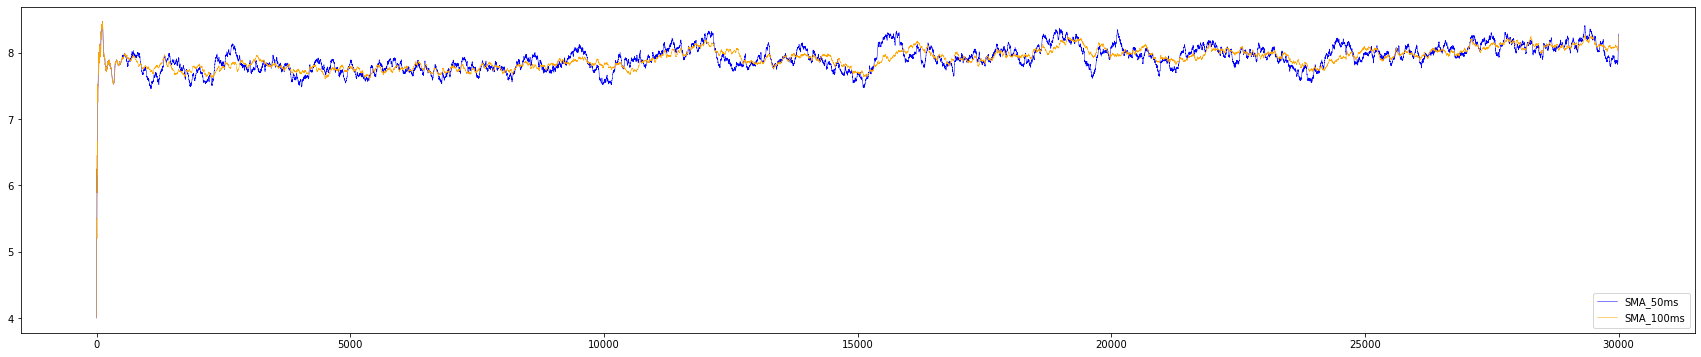

In [242]:
colors = ['blue', 'orange', 'green', 'red']

bindf[['SMA_50ms', 'SMA_100ms']].plot(color=colors, linewidth=0.5, figsize=(30,6))

In [236]:
smalldf = pd.DataFrame({'spikes_per_ms': bincount[:1000]})
smalldf["SMA_50ms"] = bindf.spikes_per_ms.rolling(50, min_periods=1).mean()
smalldf["SMA_100ms"] = bindf.spikes_per_ms.rolling(100, min_periods=1).mean()

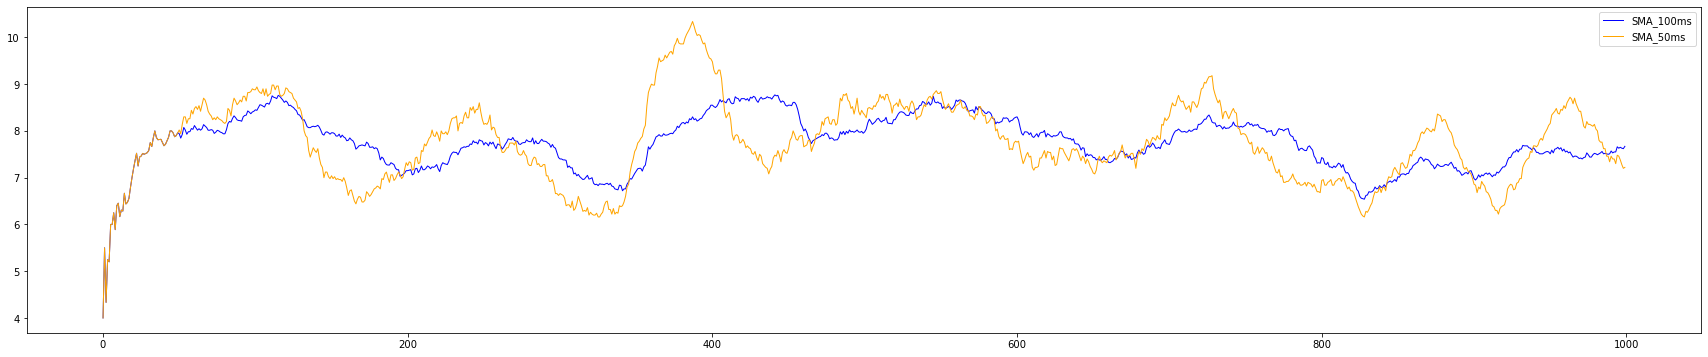

In [237]:
smalldf[['SMA_100ms', 'SMA_50ms']].plot(color=colors, linewidth=1, figsize=(30,6))